# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Файзуллов Айрат Рафагатович

**Дедлайн**: 14 октября 2023

In [2284]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2285]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [2286]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [2287]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [2288]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")

        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        if not image_transform:
          self._images = torch.tensor(images, dtype=torch.float32)
        else:
          self._images = image_transform(images.astype(np.float32))

        if not label_transform:
          self._labels = torch.tensor(labels)
        else:
          self._labels = label_transform(labels)

    def __len__(self,):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        length = len(self._labels)

        return length

    def __getitem__(self, idx):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        img = self._images[idx].reshape((28, 28))
        label = self._labels[idx]
        return img, label


In [2289]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

322
6


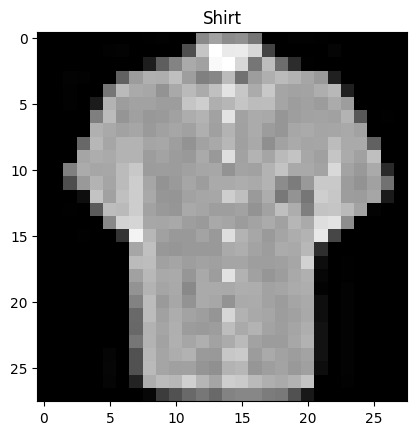

In [2290]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################

decode_type = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
    6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

rand_i = np.random.randint(len(test_dataset))

print(rand_i)
print(test_dataset[rand_i][1].item())
plt.imshow(test_dataset[rand_i][0], cmap='gray')
plt.title(decode_type[test_dataset[rand_i][1].item()])
plt.show()

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [2291]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [2292]:
transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST",
                            train=False,
                            image_transform=transform,
                            label_transform=transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform,
                             label_transform=transform
                             )

In [2293]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [2294]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [2295]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [2296]:
def collate(batch):
    ###########################################################
    ############# YOUR CODE HERE ##############################
    ###########################################################
    imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
    labels = torch.tensor([label[1].tolist() for label in batch])
    return imgs, labels

Убедитесть, что все работает корректно.

In [2297]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2,
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


In [2298]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [2299]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [2300]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [2301]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.max(torch.zeros(input.shape), input)

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors
        return grad_output * torch.where(x[0] > 0, 1.0, 0.0)


In [2302]:
class ReLU(nn.Module):
    def __init__(self):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        super().__init__()
        self.relu = ReLUFunction.apply


    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [2303]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
relu = ReLU()
x = torch.randn(2, 6, requires_grad=True)
assert gradcheck(relu, x, eps=1e-4, atol=1e-3)

In [2304]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
torch_relu = torch.nn.ReLU()
our_relu = ReLU()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [2305]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        ctx.save_for_backward(inp, weight, bias)
        output = inp  @ weight + bias
        return output
    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        (inp, weight, bias) = ctx.saved_tensors

        grad_input = grad_output @ weight.t()
        grad_weight = inp.t() @ grad_output

        grad_bias = torch.ones(len(bias))
        return grad_input, grad_weight, grad_bias

In [2306]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()

        # initialize weights with small random numbers from normal distribution
        self.weight = nn.Parameter(torch.normal(0, 1/256, size=(input_units, output_units)))
        self.bias = nn.Parameter(torch.zeros(output_units))
        self.linear = LinearFunction.apply


    def forward(self,inp):

        return self.linear(inp, self.weight, self.bias)


Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [2307]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################

linear = Linear(6, 2)
x = torch.randn((2, 6), requires_grad=True)

assert gradcheck(linear, x, eps=1e-3, atol=1e-3)

Сравнение с `PyTorch`.

In [2308]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
x = torch.randn((2, 6), requires_grad=True)
torch_linear = torch.nn.Linear(6, 2)
our_linear = Linear(6, 2)

weight_q = torch.normal(0, 1, size=(6, 2), requires_grad=True)
bias = torch.zeros(2, requires_grad=True)

state_dict = OrderedDict([("weight", weight_q.T), ("bias", bias)])

torch_linear.load_state_dict(state_dict)
state_dict = OrderedDict([("weight", weight_q), ("bias", bias)])
our_linear.load_state_dict(state_dict)


assert torch.norm(torch_linear(x.float()) - our_linear(x)) < 1e-5
###########################################################
############# YOUR CODE HERE ##############################
###########################################################

### 2.3 LogSoftmax (Log + Softmax)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Комментарий: разобраться `Log-Sum-Exp trick`

In [2309]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################

        # y = torch.exp(inp)
        # s = torch.sum(y)
        # y = torch.log(s

        y = inp - torch.log(torch.sum(torch.exp(inp), axis=1)).view(-1, 1)

        ctx.save_for_backward(y)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        y = ctx.saved_tensors
        grad_input = grad_output - grad_output.sum(axis=1, keepdims=True) * torch.exp(y[0])
        return grad_input


In [2310]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.logsoftmax = LogSoftmaxFunction.apply


    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return  self.logsoftmax(input)

Проверка градиентов.

In [2311]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################


logsoftmax = LogSoftmax()
x = torch.randn((15, 6), requires_grad=True)

assert gradcheck(logsoftmax, x, eps=1e-2, atol=1e-3)

In [2312]:
torch_softmax = torch.nn.LogSoftmax(dim=1)
our_softmax = LogSoftmax()
print(torch_softmax(x.float()))
print(our_softmax(x.float()))
print(torch.norm(torch_softmax(x.float()) - our_softmax(x.float())))

tensor([[-1.8947, -1.4744, -2.3562, -1.7705, -1.1859, -2.9912],
        [-1.2372, -2.5032, -2.2864, -1.8627, -1.1331, -3.0143],
        [-2.6036, -1.6817, -1.8773, -1.0379, -1.7427, -2.8523],
        [-0.5816, -1.6990, -2.2387, -3.1959, -2.3699, -4.0677],
        [-3.1274, -3.4741, -4.0683, -0.1943, -3.5101, -2.9048],
        [-2.9783, -0.3165, -2.4894, -4.8924, -2.7001, -2.7684],
        [-2.2611, -0.6211, -2.9859, -3.2134, -2.4607, -1.7019],
        [-3.2993, -2.9856, -1.2170, -3.2425, -1.0551, -1.4729],
        [-1.8580, -2.3331, -1.6354, -2.4970, -0.8950, -2.7937],
        [-3.4977, -0.4940, -2.0371, -2.8931, -2.8546, -2.1530],
        [-3.2599, -2.5496, -1.9801, -2.0499, -1.3608, -1.0210],
        [-1.7687, -1.4234, -4.0599, -1.0690, -4.8270, -1.5144],
        [-3.5284, -2.1272, -1.4213, -1.7543, -1.7222, -1.3533],
        [-3.0849, -1.0393, -1.4763, -1.6698, -3.5066, -1.8722],
        [-2.3879, -1.3004, -1.6742, -2.4993, -2.1524, -1.3866]],
       grad_fn=<LogSoftmaxBackward0>)
t

### 2.4 Dropout
Реализуйте слой Dropout.

In [2313]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        x = torch.bernoulli((1-p) * torch.ones_like(inp)) / (1 - p)
        ctx.save_for_backward(x, torch.tensor(p))

        return inp * x


    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        (x, p) = ctx.saved_tensors
        return grad_output * x, None

In [2314]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.dropout = DropoutFunction.apply
        self.p = p


    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        if not self.training:
          output = self.dropout(input, self.p)
        else:
          output = input
        return output

### 2.5 CrossEntropy

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь кроссэнтропию. Реализуйте функцию потерь. В разделе 2.3 приведены полезные формулы.

In [2315]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations, target):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        ctx.save_for_backward(activations, target)
        loss = torch.mean(-activations[range(activations.size(0)), target])

        return loss

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        (activations, target) = ctx.saved_tensors

        grad_input = torch.zeros_like(activations)
        grad_input[range(activations.shape[0]), target] = True

        grad_input = -grad_input * grad_output / len(target)


        return grad_input, None


class CrossEntropy(nn.Module):
    def __init__(self, ):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.crossentropy = CrossEntropyFunction.apply

    def forward(self, activations, target):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.crossentropy(activations, target)

Проверка градиентов.

In [2316]:
our_crossentr = CrossEntropy()
x = torch.randn((2, 6), requires_grad=True)
trgt = torch.randint(6, (2, ))

assert gradcheck(our_crossentr, (x, trgt), eps=1e-2, atol=1e-3)

In [2317]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################

torch_crossentr = torch.nn.CrossEntropyLoss()
our_crossentr = CrossEntropy()
x = torch.randn((2, 6), requires_grad=True)
trgt = torch.randint(6, (2, ))

assert torch.norm(torch_crossentr(x.float(), trgt).sum() - our_crossentr(our_softmax(x.float()), trgt)) < 1e-3

## 3. Сборка и обучение нейронной сети (5 балла)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [2318]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.layers = nn.ModuleList()

        self.layers.append(Linear(input_size, hidden_layers_size))
        self.layers.append(Dropout(0.5))
        self.layers.append(ReLU())

        for _ in range(num_layers-2):
          self.layers.append(Linear(hidden_layers_size, hidden_layers_size))
          self.layers.append(Dropout(0.5))
          self.layers.append(ReLU())

        self.layers.append(Linear(hidden_layers_size, num_classes))
        self.layers.append(LogSoftmax())


    def forward(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        for layer in self.layers:
            inp = layer(inp)
        return inp

    def predict(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        for layer in self.layers:
          inp = layer(inp)
        return torch.argmax(inp, dim=1)


Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать.

In [2319]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [2320]:
# accuract metric for our classififcation
def accuracy(model_labels, labels):
  #print(model_labels)
  return torch.mean((model_labels == labels).float())

In [2321]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            model_labels = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_labels, batch_labels)
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step()

            one_batch_loss = float(criterion(model_labels, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)

            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1
    return (total_loss / total_n, total_acc / total_n)

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [2322]:
model     = Network()
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropy()

In [2323]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 0 : loss 1.1476441325452178, accuracy 0.5338825583457947
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 1 : loss 0.5491086401510984, accuracy 0.8086344599723816
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 2 : loss 0.49225384333124383, accuracy 0.8311514258384705
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 3 : loss 0.469542593490798, accuracy 0.8375845551490784
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 4 : loss 0.4526301876233774, accuracy 0.8421180248260498
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 5 : loss 0.44637916130851957, accuracy 0.8446509838104248
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 6 : loss 0.4319304634318687, accuracy 0.8498013019561768
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 7 : loss 0.43346671729371883, accuracy 0.8492845892906189
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 8 : loss 0.428495947082527, accuracy 0.8509683609008789
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 9 : loss 0.4253551564901136, accuracy 0.8520345091819763
Current learning rate: 0.001


In [2326]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 0.4253551564901136, accuracy 0.8520345091819763
Current learning rate: 0.001


Видим, что модель обучилась

In [ ]:
model     = Network(num_layers=4)
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropy()

Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

Проведём эксперименты с числом слоёв

In [2342]:
model     = Network(num_layers=4)
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropy()

save_acc = []
save_loss = []

In [2343]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    save_acc.append(acc)
    save_loss.append(loss)

<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 0 : loss 0.7395468326844274, accuracy 0.7164774537086487
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 1 : loss 0.48700648699887095, accuracy 0.8310511112213135
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 2 : loss 0.4477982891011052, accuracy 0.8448506593704224
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 3 : loss 0.4311057607653784, accuracy 0.8531351685523987
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 4 : loss 0.4194346586811589, accuracy 0.8554011583328247
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 5 : loss 0.4150186154625844, accuracy 0.8569678068161011
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 6 : loss 0.4007925677623134, accuracy 0.8621342778205872
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 7 : loss 0.4039252343769185, accuracy 0.8638843297958374
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 8 : loss 0.39427274736599066, accuracy 0.8665170073509216
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 9 : loss 0.38809271637513304, accuracy 0.8694499731063843
Current learning rate: 0.001


In [2344]:
model     = Network(num_layers=3)
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropy()

save_acc3 = []
save_loss3 = []

In [2345]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    save_acc3.append(acc)
    save_loss3.append(loss)

<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 0 : loss 0.5572166333051864, accuracy 0.797798752784729
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 1 : loss 0.4480183974970132, accuracy 0.840435266494751
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 2 : loss 0.4258654814339243, accuracy 0.8489507436752319
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 3 : loss 0.40912252018880096, accuracy 0.8529180884361267
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 4 : loss 0.4000873397201067, accuracy 0.8588838577270508
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 5 : loss 0.3969304754562036, accuracy 0.8601667284965515
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 6 : loss 0.3946626074768137, accuracy 0.8616506457328796
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 7 : loss 0.39118483250960706, accuracy 0.8629835844039917
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 8 : loss 0.3839629437113763, accuracy 0.8643172979354858
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 9 : loss nan, accuracy 0.10225153714418411
Current learning rate: 0.001


In [2346]:
model     = Network(num_layers=2)
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropy()

save_acc2 = []
save_loss2 = []

In [2347]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    save_acc2.append(acc)
    save_loss2.append(loss)

<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 0 : loss 0.7032291752719321, accuracy 0.7172958850860596
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 1 : loss 0.6607059539975598, accuracy 0.7316970229148865
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 2 : loss inf, accuracy 0.3187549114227295
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 3 : loss inf, accuracy 0.10000135004520416
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 4 : loss inf, accuracy 0.10000143200159073
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 5 : loss inf, accuracy 0.10000135749578476
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 6 : loss inf, accuracy 0.10000155121088028
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 7 : loss inf, accuracy 0.10000139474868774
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 8 : loss inf, accuracy 0.10000152885913849
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 9 : loss inf, accuracy 0.1000015065073967
Current learning rate: 0.001


In [2357]:
model     = Network(num_layers=1)
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropy()

save_acc6 = []
save_loss6 = []

In [2358]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    save_acc6.append(acc)
    save_loss6.append(loss)

<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 0 : loss 0.6492692687623203, accuracy 0.77011638879776
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 1 : loss 0.5930316600701772, accuracy 0.7954850196838379
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 2 : loss 0.5864302387251519, accuracy 0.7993838787078857
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 3 : loss 0.5670293176553678, accuracy 0.8043672442436218
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 4 : loss 0.5762810328477063, accuracy 0.8036169409751892
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 5 : loss 0.5614959933268837, accuracy 0.8075357675552368
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 6 : loss 0.5711254649232141, accuracy 0.803518533706665
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 7 : loss 0.5622398548149504, accuracy 0.8097509145736694
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 8 : loss 0.584019125275896, accuracy 0.7995696663856506
Current learning rate: 0.001


<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()
<ipython-input-2296-a60754b173b7>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.tensor([np.ravel(img[0].tolist()) for img in batch]).float()


Epoch - 9 : loss 0.5561237859255634, accuracy 0.8124681115150452
Current learning rate: 0.001


In [2348]:
x1 = np.arange(10)
x1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [2349]:
save_acc

[tensor(0.7165),
 tensor(0.8311),
 tensor(0.8449),
 tensor(0.8531),
 tensor(0.8554),
 tensor(0.8570),
 tensor(0.8621),
 tensor(0.8639),
 tensor(0.8665),
 tensor(0.8694)]

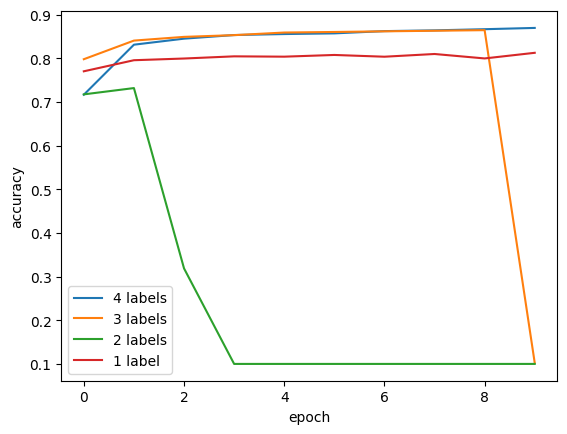

In [2359]:
plt.plot(x1, save_acc, label="4 labels")
plt.plot(x1, save_acc3, label="3 labels")
plt.plot(x1, save_acc2, label="2 labels")
plt.plot(x1, save_acc6, label="1 label")
# plt.plot(x1, b_basic, label = "basic")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### Вывод

Можно сделать вывод, что на 4 слоях сеть показывает наилучшее предсказание.

Также можно заметить, что с 2 и 3 слоями она дала нам плохой результат. Скорее всего это связано с начальной инициализацией весов. Стоило их инициализорвать методом, предназначенным для функции активации ReLU.

Ещё есть интересное наблюдение: даже с 1 слоем сеть довольно хорошо обучилась и теперь способно с неплохой точностью распознавать картинки.

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [2325]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.